<a href="https://colab.research.google.com/github/cleecfa/predictive_analytics_loan_risk/blob/main/Copy_of_CG_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Optimize Finding Loan Prospects Based on Customer's Payment Behavior**


---

**Background**
> The primary threat faced by banks is credit risk. Loss of loan extended to borrowers severely disrupts the lender's cash flows, increase collection costs, and at worst can cause the lenders to go bankrupt.

> The Imperial Galactic Bank (IGB) has been historically struggling with loan defaults. However, IGB has no room to take its foot off the gas. Due to recent hike in competition, they have to increase the volume of loans to survive. Furthermore, IGB's management has a mission to increase profits to support the great Emperor Palpatine’s new Death Star venture project.


**Goal**


>*   Investigate IGB's credit usage data to learn about attributes that are associated with late/missed payments.
*   Build a statistical solution that IGB's management can consider and apply to future loans to reduce the probability of default.  


**Credit Usage Data**


> The data is privately stored in Google Drive. Only someone who has the credentials can access this Google Colab Notebook as well as the source data. 

**How to run the code:**

1. Click Runtime, then Run All.
2. In the output of the first cell, you will see a link for log in to access the verification code.
3. Click the link and use the given ID / PW to log in.
4. Click "Allow"
5. Copy the verification code then enter into the "Enter verification code:" box.


>*   ID: capgroupinterview1@gmail.com
>*   PW: ********** (The password will be provided via email.)




**Process**


1. Data Cleaning, Merging, and Wrangling.
2. Capital Group Case Study Questions.
    * Exploratory Data Analysis (EDA)
    * Data visualization
    * Data Analysis
3. KNN Supervised Classification Algorithm.





---




# **Data Cleaning, and Wrangling**



**a) Load in the credit data from Google Sheet**



In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open('credit').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# Build a DF and convert to a proper format
import pandas as pd
df = pd.DataFrame.from_records(rows)
df.head(2)

TypeError: ignored

**b) Move the first row to the header.**

In [ ]:
credit = df.rename(columns=df.iloc[0])[1:] # Convert the first row to column names and remove the original first row
credit.head()

In [ ]:
credit.info() # The original data is in string format. Update data types to proper formats in the next cell.

In [ ]:
# Update data types to numeric
for col in ['LIMIT_BAL','SEX','EDUCATION',	'MARRIAGE','AGE','PAY_0','PAY_2','PAY_3',
            'PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5',	'BILL_AMT6',	'PAY_AMT1',	
            'PAY_AMT2',	'PAY_AMT3',	'PAY_AMT4',	'PAY_AMT5',	'PAY_AMT6',	'default.payment.next.month',	'average_income']:
  credit[col] = pd.to_numeric(credit[col])

# Update to datetime
# credit['account_creation_date']=pd.to_datetime(credit['account_creation_date'].astype(str), format='%m/%d/%Y')

credit.info()

In [ ]:
# Check any null values.
# The data is good up to this point because there are no null values.
credit.isnull().sum()

NameError: ignored

**c) Update column names**

In [ ]:
# For consistency with other sequential cols, update PAY_0 to PAY_1.
# Simplify the default.payment.next.month column. 
credit = credit.rename({'PAY_0': 'PAY_1', 'default.payment.next.month': 'def'}, axis=1)
# credit['def'] = credit['default'] #Adding 'def because there is a conflict using 'default' in SQL later ..
credit.head(2)

**d) Handle Data Anomalies**

In [ ]:
# EDUCATION Field
# 0, 5, 6 that are not inconsistent with the field definition provided in the case study guideline. I will consider them to be 4 = "others" as well.
print('Original EDUCATION Field:', credit['EDUCATION'].unique())
# Update the Education Field
credit.loc[(credit['EDUCATION'] == 0) | (credit['EDUCATION'] == 5) | (credit['EDUCATION'] == 6), 'EDUCATION'] = 4
print('New EDUCATION Field:', credit['EDUCATION'].unique(), 'where 4 = others')

In [ ]:
# MARRIAGE Field
# There is also 0 in the dataset that's not mentioned in the case study guideline. I will consider it to be 3 = "others"  as well.
print('Original MARRIAGE Field:', credit['MARRIAGE'].unique())
credit.loc[credit['MARRIAGE']==0, 'MARRIAGE'] = 3
print('New MARRIAGE Field:', credit['MARRIAGE'].unique(), 'where 3 = others')


In [ ]:
# GENDER
# I believe the GENDER Field is the SEX column in the dataset.
credit['SEX'].unique() # Looks like this is consistent with the description.

In [ ]:
# PAY_X
# This is the most important field to fix. I see 0 and -2 with the question mark in the in the case study guideline. 
# *** Assumption: *** For this case study, I will assume that these are also indicating paid on time.
print('Original PAY_1 Field:', credit['PAY_1'].unique())
credit.loc[(credit['PAY_1'] == 0) | (credit['PAY_1'] == -2), 'PAY_1'] = -1
print('New PAY_1 Field:', credit['PAY_1'].unique(), 'where 0 and -2 are deemed paid duly')

# Do the same thing for other PAY columns
credit.loc[(credit['PAY_1'] == 0) | (credit['PAY_1'] == -2), 'PAY_1'] = -1
credit.loc[(credit['PAY_2'] == 0) | (credit['PAY_2'] == -2), 'PAY_2'] = -1
credit.loc[(credit['PAY_3'] == 0) | (credit['PAY_3'] == -2), 'PAY_3'] = -1
credit.loc[(credit['PAY_4'] == 0) | (credit['PAY_4'] == -2), 'PAY_4'] = -1
credit.loc[(credit['PAY_5'] == 0) | (credit['PAY_5'] == -2), 'PAY_5'] = -1
credit.loc[(credit['PAY_6'] == 0) | (credit['PAY_6'] == -2), 'PAY_6'] = -1



```
# This is formatted as code
```

# Assumptions on the default column
After investigating this column by comparing it to the PAY_X columns, I don't believe the default column implies actual default status on any of the previously billed amounts. For example, ID 1033 has all bill amounts duly paid but the default column still shows default.

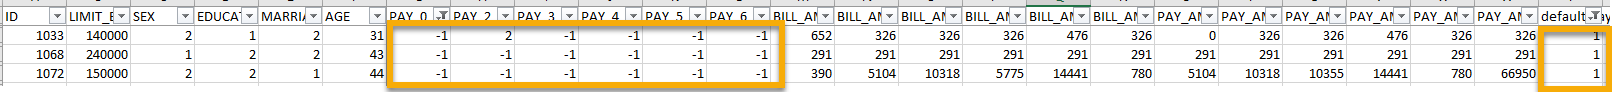

Since the original column name "default.payment.next.month" says "next month", I will assume this column indicates the payment status on the following month which is October. This column will be my dependent variable in this case study.

**e) Overall Default Rate for the next month (October)**

In [ ]:
display("Overall default rate:")
display(str(credit['def'].sum()/credit['def'].count()) + "%")

# **Capital Group Case Study**

## **Question 1**
How would you define a target variable “default” to measure late payments? Please explain.


---

**Answer:** The target variable is the variable whose values are to be modeled by other variables called independent variables. The target variable must carry all the information that summarizes the outcome we would like to predict from the model. In our case, the goal is to minimize the likelihood of future defaults. Therefore, knowing the exact definition of “default” is very important. Unfortunately, the description of the default field in the case study guideline only provides basic information “default (Yes=1, No=0)”. This field can be translated to many different notions. For example, it could mean any historical missed payments, any historical insufficient payment, or default on the next payment and etc. The actual data does not convince me whether I should use any other column as the Target variable other than the default column. Especially, when I am not convinced to use the PAY_X columns as my target variable (The reasons are given in my answer to the question #2).  
The default column name (column Y) in the actual data shows “default.payment.next.month” which implies the status of payment in the next month which is October. I would use this column as my target variable because we are interested in knowing the probability of default in the future.


## **Question 2**
Do you have other ways to define it? What are the pros and cons for these different definitions?


---

**Answer:** Alternative ways to define the target variable:



*   Any historical missed payments defined as default
*   Any historical insufficient payments defined as default 


The main advantage of this method is that it provides larger sample sizes (using a single default column only VS. using all PAY_X columns). It also provides more stories (just being classified as default VS. how much default). This way of defining the target variable, however, requires accuracy in BILL_AMT and PAY_AMT columns. Unfortunately, I have found that the relationship between the values of BILL_AMT and PAY_AMT columns are not consistent with the payment status in the PAY_X column. For example, the ID 12 shows there was a bill amount of 13668 in April, but nothing was paid in May. Which means the PAY_5 column should show a value higher than -1 because the payment was not made on time. There is also one more example which logically does not make sense. ID 599 shows PAY_0 = 2 when all of PAY_2~6  show zero. A payment cannot be delayed 2 months when there was no delay in all preceding months. There are several other examples that continue to show inconsistencies between these variables, but I am not going to list all of them here. For this reason, I would not use the second method of customarily defining the target variable using the outcomes of the relationship between the BILL_AMT and PAY_AMT. I would rather use the default column given in the credit dataset.  


## **Question 3**
Please code up the target variable, based on X6 to X11, using SQL.


---

**Answer:** Since the question requires using columns X6-X11, I will use the alternative way to define the target variable mentioned in the question 2 for this question only. Please see the SQL statement below.

In [ ]:
import sqlite3 as sq

# Function to run SQL
def run_credit_sql(source_data_frame, statement):
  source_data_frame = credit
  run_statement = statement

  sql_data = 'D:\\credit.sqlite'
  conn = sq.connect(sql_data)
  cur = conn.cursor()
  cur.execute('''DROP TABLE IF EXISTS credit''')
  source_data_frame.to_sql('credit_sql', conn, if_exists='replace', index=False) # Write the source_data_frame to SQLIte Database
  output_in_df = pd.read_sql(run_statement, conn)
  conn.commit()
  conn.close()
  display(output_in_df)

q3_answer = '''
SELECT
ID,
(CASE WHEN  BILL_AMT6 > PAY_AMT5 OR BILL_AMT5 > PAY_AMT4 OR BILL_AMT4 > PAY_AMT3 OR BILL_AMT3 > PAY_AMT2 OR BILL_AMT2 > PAY_AMT1 THEN 1 ELSE 0 END) AS default_in_any_period
FROM credit_sql;
'''

run_credit_sql(credit, q3_answer)

## **Question 4**
Please bin age (X5) into different bins with SQL and describe why you choose the binning method.


---

**Answer:** I binned the data (Please see the SQL query below) based on the 
25%, 50%, 75% percentile of the AGE values in our dataset.(Please see the supporting views in the following cells.) These bins are then labeled as Younger_Millennials, Older_Millennials, Gen_X, and Baby_Boomers, respectively. 

The reason why I chose this method is because it's not too narrow or wide. I believe the four major demographic age groups well represent the entire potential bank customers who are older than the age of 18. If I use age bins that are too wide, it can potentially hide important details about the distribution. If I use bins that are too narrow, it may draw my attention to the data noise, not to the important information about the distribution.

Interestingly, the age bins driven by percentile results similar bin sizes to the financial demographic cohorts defined in the [study done by CNBC](https://www.cnbc.com/2018/08/20/how-much-debt-americans-have-at-every-age.html) using the actual personal financial data from Northwestern Mutual.

Note: **Additional Answer in the code output below.**

In [ ]:
q4_answer = '''SELECT age_range_bins FROM
(
 SELECT CASE 
 WHEN AGE BETWEEN 18 AND 24 THEN 'Younger_Millennials'
 WHEN AGE BETWEEN 25 AND 34 THEN 'Older_Millennials'
 WHEN AGE BETWEEN 35 AND 49 THEN 'Gen_X'
 WHEN AGE BETWEEN 50 AND 80 THEN 'Baby_Boomers'
 END AS age_range_bins
 FROM credit_sql
) t
GROUP BY age_range_bins
ORDER BY age_range_bins;'''

display("*" * 200)
display("Answer for Question 4:")
display("*" * 200)
display(q4_answer )
display("*" * 200)
display("Output for Question 4:")
display("*" * 200)
run_credit_sql(credit, q4_answer)



In [ ]:
# Also create age_group in the credit dataframe to show in Python
def generate_group_bins (age):
        if age <= 24 :
            return "Younger_Millennials"
        elif age >= 25 and age <= 34 :
            return "Older_Millennials"
        elif age >= 35 and age <= 49 :
            return "Gen_X"
        elif age >= 50:
            return "Baby_Boomers"
        else:
            return None

credit["Age_group_bins"] = credit["AGE"].apply(generate_group_bins)

Mid-sized Bins based on percentile - It captures the U-shape in the default distribution across different age groups. 

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize = (15 , 8))
sns.barplot(x = credit['Age_group_bins'], y = credit['def'], palette='ch:start=.2,rot=-.3', ci=None)
plt.show()

Example of too wide bins - It hides the fact that the Younger Millennials tend to have high default rates. 

In [ ]:
def get_group (age):
        if age < 40:
            return "Young"
        elif age >= 60:
            return "Old"
        else:
            return "Mid"

credit["age_group_wide"] = credit["AGE"].apply(get_group)

plt.figure(figsize = (15 , 8))
sns.barplot(x = credit['age_group_wide'], y = credit['def'], palette='ch:start=.2,rot=-.3', ci=None)
plt.show()

## **Question 5**
Please provide counts and average default rate for each age group using SQL.


---


**Answer:** 

In [ ]:
#Default Rate = number of zeros in the default column / total count of the default column

q5_answer ='''
SELECT
  age_range_bins,
  COUNT(*) count,
  AVG(def) AS average_default_rate
FROM
  (SELECT 
  AGE,
  (CASE 
  WHEN AGE BETWEEN 18 AND 24 THEN 'Younger_Millennials'
  WHEN AGE BETWEEN 25 AND 34 THEN 'Older_Millennials'
  WHEN AGE BETWEEN 35 AND 49 THEN 'Gen_X'
  WHEN AGE BETWEEN 50 AND 80 THEN 'Baby_Boomers'
  END) AS age_range_bins,
  def
  FROM credit_sql) t
GROUP BY age_range_bins;
'''

display("*" * 200)
display("Answer for Question 5:")
display("*" * 200)
display(q5_answer )
display("*" * 200)
display("Output for Question 5:")
display("*" * 200)
run_credit_sql(credit, q5_answer)

## **Question 6**
Please compile a data dictionary given the excel.


---



**Answer:** Please find the data dictionary of the credit table [here](https://docs.google.com/spreadsheets/d/18cmIybjI27RYPea-xenkq2dz_3on3fdN2Gxj6fMHOlw/edit#gid=0)

## **Question 7**
Simulate cities and accounts tables. Use the given Excel as the credit table data.


---


**My Assumptions and Approach:** Since the two additional tables (cities and accounts) are supposed to be additional descriptive information for the records in the credit table, I would do a LEFT JOIN with the credit table (with credit table on the left side). Because the accounts table has no primary key to the cities table, I will assume that the accounts table also has a city_id which I would use to join the two tables. Below is an example of SQL query that simulates creating tables (cities and accounts) using a **SELECT statement and VALUES** for the purpose of addressing the read-only access. Please note the data I will be using for all remaining questions has been manually put together with dummy data. 

Additional Assumptions:
* There are five cities which includes ‘Tatooine’ and ‘Alderaan’.
* Every borrowers are associated with at least one city.
* A borrower can have multiple accounts.  

Please see below for the SQL Statement.

In [ ]:
'''SELECT credit.*, cities.*, accounts.*
FROM credit 
LEFT JOIN (SELECT accounts.*
FROM (VALUES (1, 39037, 'c2', ‘active', ‘2010/05/30’),
             (2, 38831, 'c1', 'dormant', ‘2001/01/01’) -- It will be a lot longer syntax in real life where there is a lot more records. I am just simplifying it.
     ) accounts(borrower_id, account_id, city_id, account_status, account_creation_date)
ON credit.id = accounts.borrower_id
LEFT JOIN (SELECT cities.*
FROM (VALUES ('c1', Tatooine, 80000),
             ('c2', Alderaan, '150000')
     ) cities(city_id, city_name, , average_income)
ON accounts.city_id = cities.city_id;
'''

The Bank is prospecting two new cities ‘Tatooine’ and ‘Alderaan’.  For these cities estimate their likely payments: calculate 95th percentile of all payments made for all active accounts that is created between January 1st 2005 and August 30th 2005.


---



Please see below for the SQL Statement. Please note, **sqlite doesn't support** **some of the window function used in the statement**. 

In [ ]:
"""
SELECT
city_name,
percentile_cont(0.95) within group (order by sum(PAY_AMT1+PAY_AMT2+PAY_AMT3+PAY_AMT4+PAY_AMT5+PAY_AMT6)) over () as Total_PAY_percentile_95
FROM credit_sql
WHERE account_status = 'active' 
  AND date(account_creation_date) BETWEEN '2005/01/01' AND '2005/08/30'
  AND city_name IN ('Tatooine', 'Alderaan')
GROUP BY city_name;
"""

For each cities ‘Tatooine’ and ‘Alderaan’ and each account creation month, calculate the percentage of default for all active accounts where the default month is within 3 months of the creation month.


---

Please see below for the SQL Statement.

In [ ]:
q7c = """
SELECT 
city_name,
SUM(def) AS total_defaults,
COUNT(def) AS total_loans,
(SUM(def)*1.0 / COUNT(def)*1.0) * 100 AS percentage_of_default -- convered to floating point
FROM credit_sql
WHERE account_status = 'active' 
  AND date(account_creation_date) BETWEEN DATE(date(account_creation_date), '-3 months') AND DATE(date(account_creation_date), '+3 months')
  AND city_name IN ('Tatooine', 'Alderaan')
GROUP BY city_name;
"""
run_credit_sql(credit, q7c)

# **EDA, Data Analysis, and Data Visualization**

## **Question 8**
Create visualizations to understand descriptive data of the Bank’s customers (Question 5) and to understand expected outlook for ‘Tatooine’ and ‘Alderaan’ (Question 7). Extra credit by using Python or R. 


---



**Answer:** Please see the outputs from below cells.

Overview of basit statistics of the independent variables.

In [ ]:
credit.describe().T

Sample size: 30,000 borrowers


**Drivers for the Default Target Variable**


---


Correlations between potential independent variables and the defined target variable (default).





In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize = (15, 15))   
# this is to set fig size

corr_mat = credit.corr() # Create corr mat calculation object
mask = np.triu(np.ones_like(corr_mat, dtype = np.bool))
cmap = sns.diverging_palette(900, 5, as_cmap = True)
sns.heatmap(corr_mat,        
            mask = mask,
            cmap = cmap,                 # set color range of the data
            vmax = 1,                    # affects the color range of the data
            center = 0,                  # also affects the color range of the data
            square = True,               
            annot= True,                 # annotation
            fmt=".1f",                   # 1 decimal place
            linewidths = 1,              # affects line width
            cbar_kws = {"shrink": 0.8})  #shrink color bar by 0.8 times

* Negative correlation between the credit limit (LIMIT_BAL) and default, the target variable (def) - Borrowers with good credit history are given higher credit limit by banks. **The higher the credit limit for a borrower, the less likely the borrower will default.** 

* Positive correlation between delayed payment duration in previous months (PAY_X) and the target variable (def). This implies **the longer the payment delayed in previous months, the more likely the borrower will default in the following month.** 

* Also, notice the correlation becomes higher as you move from PAY_6  to PAY_1. This implies the duration of delayed payment **in more recent month tends to impact the default in the following month more**.   


In [ ]:
for col in credit.loc[:, ['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']]:
  credit['any_delay'] = credit[col].apply(lambda x: "previously delayed" if x > 0 else "never delayed")

credit['Delayed_in_Most_Recent_Month'] = credit['PAY_1'].apply(lambda x: "Has been delayed" if x > 0 else "Not delayed")


plt.figure(figsize=(15,8))
sns.barplot(x=credit['Delayed_in_Most_Recent_Month'], y ="def", data=credit, edgecolor=".1", 
            ci=None, 
            palette="YlOrBr", 
            hue='PAY_1')
plt.title('Default Ratio VS. Delay Status in the Most Recent Month')

plt.figure(figsize=(15,8))
sns.barplot(x=credit['any_delay'], y ="def", data=credit, edgecolor=".1", ci=None, palette=["#F8F3CC","#7D3716"])
plt.title('Default Ratio VS. Any Delay In the Past')

plt.show()



**Relationships Between Different Demographic Characteristics and the Default**


---

Age Group VS. Default Rate


*   There is a **U-Shape** in the default distribution across the age groups.
*   The Older_Millennials group **(between age of 25 and 34) shows the lowest default rate**.






In [ ]:
plt.figure(figsize = (15 , 8))
sns.barplot(x = credit['Age_group_bins'], y = credit['def'], palette='ch:start=.2,rot=-.3', edgecolor=".1")
plt.show()

Other Demographic Attributes VS. Default Rate

In [ ]:
def get_gender (gender):
        if gender == 1:
            return "Male"
        elif gender == 2:
            return "Female"
        else:
            return None

def get_education (education):
        if education == 1:
            return "Graduate School"
        elif education == 2:
            return "University"
        elif education == 3:
            return "High School"
        else:
            return "Others"

def get_marital_status (m):
        if m == 1:
            return "Married"
        elif m == 2:
            return "Single"
        elif m == 3:
            return "Others"
        else:
            return None


credit["gender_desc"] = credit["SEX"].apply(get_gender)
credit["education_desc"] = credit["EDUCATION"].apply(get_education)
credit["marital_status_desc"] = credit["MARRIAGE"].apply(get_marital_status)

demo_ch = ['gender_desc','education_desc', 'marital_status_desc']

for col in demo_ch:
  plt.figure(figsize = (10 , 5))
  dim_sum = credit.groupby(col).sum()['def']
  sns.barplot(x = credit[col], y = credit['def'], data = credit, palette="ch:start=.2,rot=-.3", edgecolor=".1")
  plt.show()



*   Male borrowers have higher default rate than Female borrowers.
*   Married borrowers have higher default rate than single borrowers.
*   Borrowers with more advanced education background have lower default rate. 

**Alderaan VS. Tatooine**


---
There is no attribute that clearly distinguishes different outlook for these two cities. Overall, **the citizens of Alderan have slightly higher default rate (~0.5%) than the citizens of Tatooine.**


In [ ]:
df_cities = credit.loc[(credit['city_name'] == 'Alderaan') | (credit['city_name'] == 'Tatooine')]
plt.figure(figsize = (10 , 5))
sns.barplot(x = df_cities['def'], y = df_cities['city_name'], data = credit, palette="ch:start=.2,rot=-.3", edgecolor=".1")
plt.show()

# **Predictive Model for Future Prospecting**


---
Build a basic predicive model using some of the main features (independent variables). First, split the dataset to features and target. 

In [ ]:
from sklearn.model_selection import train_test_split

#new dataset for machine learning, then separate independent variable from the target variable.
credit_X = credit[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']] #indep
credit_y = credit[['def']] #target


Split the dataset to train (80%) and test (20%). To split the labels in train and test set as they are in the original dataset,use the stratify argument.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(credit_X, credit_y,test_size=0.2, random_state=42, stratify=credit_y)

Use a simple supervised classification model, KNN (k-nearest neighbors algorithm) to predict the target classification. Set up the KNN classifier with the value of k at 1. Then fit the model.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

Accuracy score at ~ 73%

In [ ]:
knn.score(X_test,y_test)

In [ ]:
np.arange(1,9)

Try to adjust the value of k to see different accuracy scores from the model.

In [ ]:
#Place for k from 1 to 8 
nb = np.arange(1,9)
train_acc =np.empty(len(nb))  
test_acc = np.empty(len(nb))

for i,k in enumerate(nb):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    train_acc[i] = knn.score(X_train, y_train) # store arrays of accuracy scores on the training set
    test_acc[i] = knn.score(X_test, y_test) # store arrays of accuracy scores on the test set

In [ ]:
plt.title('KNN at different number of neighbors')
plt.plot(nb, test_acc, label='Accuracy on the Training Data')
plt.plot(nb, train_acc, label='Accuracy on the Testing Data')
plt.legend()
plt.xlabel('Number of K neighbors')
plt.ylabel('Accuracy')
plt.show()

The testing accuracy is highest at k=8. Run the KNN model at k=8 again.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train,y_train)

The testing accuracy improved from ~73% to ~80%.

In [ ]:
#Get accuracy. Note: In case of classification algorithms score method represents accuracy.
knn.score(X_test,y_test)

## How can IGB utilize this classification model?


> This model can be used for IGB management to predict the probability of default on its existing customers. When extending additional loans to existing customers, they can feed the trained model with updated data. The model then provides a data-driven insight on how much likely the customer will default (with classification of 1 = default or 0 = not default) in the next pay period with  approximately 80% accuracy.